In [1]:
import torch
from diffusers import ControlNetModel, UniPCMultistepScheduler, AutoencoderKL
from custom_i2i_pipeline import CustomStableDiffusionControlNetImg2ImgPipeline
from controlnet_aux import CannyDetector
from PIL import Image
import torchvision.transforms as transforms 
from transformers import AutoModel, AutoImageProcessor
from utils import color_match

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

transform_size_to_512 = transforms.Compose([
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(512),
        ])

DIFFUSION_MODEL = 'SG161222/Realistic_Vision_V4.0_noVAE'
SPATIAL_CONTROL_PATH = 'spatialnet_ckp/spatial_control_ckp_14000'
SEMANTIC_CONTROL_PATH = 'semanticnet_ckp'
SEMANTIC_CONTROL_NAME = 'semantic_control_ckp_435000.bin'
IMAGE_ENCODER = 'facebook/dinov2-giant'
VAE = 'stabilityai/sd-vae-ft-mse'

spatialnet = [ControlNetModel.from_pretrained(SPATIAL_CONTROL_PATH, torch_dtype=torch.float16)]
pipe = CustomStableDiffusionControlNetImg2ImgPipeline.from_pretrained(DIFFUSION_MODEL, \
                                                         controlnet=spatialnet, \
                                                         torch_dtype=torch.float16,
                                                         safety_checker = None,
                                                         requires_safety_checker = False
                                                         )
pipe.costum_load_ip_adapter(SEMANTIC_CONTROL_PATH, subfolder='models', weight_name=SEMANTIC_CONTROL_NAME)
pipe.image_encoder = AutoModel.from_pretrained(IMAGE_ENCODER).to(device, dtype=torch.float16)
pipe.feature_extractor = AutoImageProcessor.from_pretrained(IMAGE_ENCODER)
pipe.vae = AutoencoderKL.from_pretrained(VAE).to(dtype=torch.float16)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.set_ip_adapter_scale(1.0)
pipe.set_progress_bar_config(disable=True)
pipe.to(device)

processor = CannyDetector()

def ctrl_regen_plus(input_img, step, seed=0):
    generator = torch.manual_seed(seed)
    input_img = transform_size_to_512(input_img)
    processed_img = processor(input_img, low_threshold=100, high_threshold=150)
    prompt = 'best quality, high quality'
    negative_prompt = 'monochrome, lowres, bad anatomy, worst quality, low quality'
    output_img = pipe(prompt,
                      negative_prompt=negative_prompt,
                      image = [input_img],
                      control_image = [processed_img], # spatial condition
                      ip_adapter_image = [input_img],   # semantic condition
                      strength = step,
                      generator = generator,
                      num_inference_steps=50,
                      controlnet_conditioning_scale = 1.0,
                      guidance_scale = 2.0,
                      control_guidance_start = 0,
                      control_guidance_end = 1,
                      ).images[0]
    output_img = color_match(input_img, output_img)
    return output_img


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

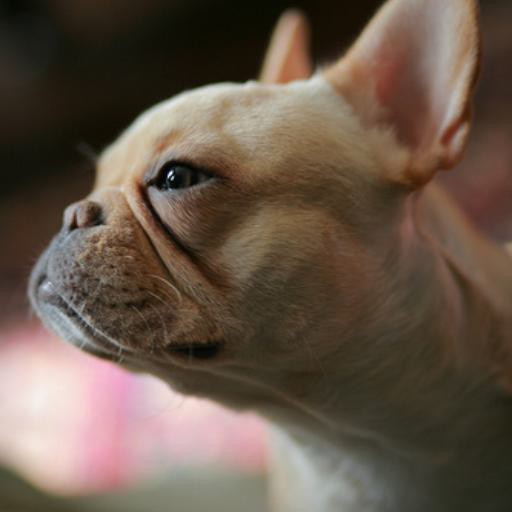

In [3]:
IMAGE_PATH = 'examples/1.jpg'
input_img = Image.open(IMAGE_PATH)
input_img

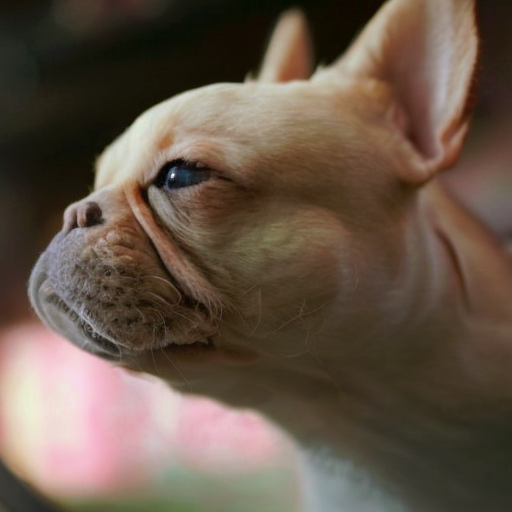

In [4]:
IMAGE_PATH = 'examples/1.jpg'
input_img = Image.open(IMAGE_PATH)
# step could be between 0 and 1; change seed to get different regeneration results
output_img = ctrl_regen_plus(input_img=input_img, step=0.5, seed=1)
output_img